# Using the Augmented Lagrangian function.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cooper-org/cooper/blob/master/docs/source/notebooks/plot_augmented_lagrangian.ipynb)



This tutorial demonstrates how to use the {py:class}`~cooper.formulations.AugmentedLagrangian` formulation to solve constrained optimization problems in Cooper. We illustrate its usage and advantages over the {py:class}`~cooper.formulations.QuadraticPenalty` formulation with a simple 2D example from {cite:p}`nocedal2006NumericalOptimization`.

In [2]:
%%capture
# %pip install cooper-optim
%pip install --index-url https://test.pypi.org/simple/ --no-deps cooper-optim  # TODO: Remove this line when cooper deployed to pypi

In [3]:
import matplotlib.pyplot as plt
import torch

import cooper

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Problem Formulation

We consider the following constrained optimization problem (Problem 17.3 from {cite:t}`nocedal2006NumericalOptimization`) with a single equality constraint:

$$
\min_{\boldsymbol{x} \in \mathbb{R}^2} f(\boldsymbol{x}) = x_1 + x_2 \quad \text{s.t.} \quad x_1^2 + x_2^2 = 2.
$$

The unique solution is $\boldsymbol{x}^* = (-1, -1)$.

The code below implements this constrained minimization problem.

In [4]:
class Problem2D(cooper.ConstrainedMinimizationProblem):
    def __init__(self, formulation_type):
        super().__init__()

        if not formulation_type.expects_multiplier:
            self.multiplier = None
        else:
            self.multiplier = cooper.multipliers.DenseMultiplier(num_constraints=1, device=DEVICE)

        if not formulation_type.expects_penalty_coefficient:
            self.penalty = None
        else:
            self.penalty = cooper.penalty_coefficients.DensePenaltyCoefficient(
                init=torch.tensor(0.0, device=DEVICE),
            )

        self.constraint = cooper.Constraint(
            constraint_type=cooper.ConstraintType.EQUALITY,
            formulation_type=formulation_type,
            multiplier=self.multiplier,
            penalty_coefficient=self.penalty,
        )

    def compute_cmp_state(self, x):
        objective = torch.sum(x)  # x1 + x2
        constraint = torch.sum(x**2) - 2  # x1^2 + x2^2 - 2 = 0

        constraint_state = cooper.ConstraintState(violation=constraint)

        return cooper.CMPState(loss=objective, observed_constraints={self.constraint: constraint_state})

The Augmented Lagrangian function associated with this problem is:

$$
\mathcal{L}_{c}(\boldsymbol{x}, \mu) = x_1 + x_2 + \mu (x_1^2 + x_2^2 - 2) + \frac{c}{2} (x_1^2 + x_2^2 - 2)^2,
$$

where $\mu$ is the Lagrange multiplier associated with the equality constraint, and $c$ is the penalty parameter.

We will also consider the Quadratic Penalty function associated with this problem:

$$
\mathcal{P}_{c}(\boldsymbol{x}) = x_1 + x_2 + \frac{c}{2} (x_1^2 + x_2^2 - 2)^2.
$$

Both of these formulations are instantiated in the following code block:

## Solving the Problem

In [5]:
X_STAR = torch.tensor([-1.0, -1.0], device=DEVICE)


def train(problem, x, primal_lr, momentum, dual_lr, penalty_increment, n_steps):
    has_dual_variables = problem.multiplier is not None

    primal_optimizer = torch.optim.SGD([x], lr=primal_lr, momentum=momentum)

    if has_dual_variables:
        dual_optimizer = torch.optim.SGD(problem.dual_parameters(), lr=dual_lr, maximize=True)

        constrained_optimizer = cooper.optim.SimultaneousOptimizer(
            cmp=problem,
            primal_optimizers=primal_optimizer,
            dual_optimizers=dual_optimizer,
        )
    else:
        # Formulations without dual variables, such as the Quadratic Penalty
        # formulation, do not require a dual optimizer
        constrained_optimizer = cooper.optim.UnconstrainedOptimizer(
            cmp=problem,
            primal_optimizers=primal_optimizer,
        )

    # Increase the penalty coefficient by `increment` if the constraint is violate by more
    # than `violation_tolerance`
    penalty_scheduler = cooper.penalty_coefficients.AdditivePenaltyCoefficientUpdater(
        increment=penalty_increment,
        violation_tolerance=1e-3,
    )

    dist_2_x_star, multipliers, penalty_coefficients = [], [], []

    for _ in range(n_steps):
        roll_out = constrained_optimizer.roll(compute_cmp_state_kwargs={"x": x})

        # Update the penalty coefficient
        constraint_state = roll_out.cmp_state.observed_constraints[problem.constraint]
        penalty_scheduler.update_penalty_coefficient_(problem.constraint, constraint_state)

        multiplier_value = problem.multiplier.weight.item() if has_dual_variables else None
        penalty_coefficient_value = problem.constraint.penalty_coefficient().item()

        dist_2_x_star.append(torch.norm(x - X_STAR).item())
        multipliers.append(multiplier_value)
        penalty_coefficients.append(penalty_coefficient_value)

    return x, dist_2_x_star, multipliers, penalty_coefficients

In [6]:
primal_lr = 1e-2
momentum = 0.9
penalty_increment = 1e-2
n_steps = 5_000

# Only required for Augmented Lagrangian formulation
dual_lr = 1e-2

x_qp = torch.tensor([1.0, 1.0], device=DEVICE, requires_grad=True)
x_al = torch.tensor([1.0, 1.0], device=DEVICE, requires_grad=True)

QP_Problem = Problem2D(cooper.formulations.QuadraticPenalty)
AL_Problem = Problem2D(cooper.formulations.AugmentedLagrangian)

x_qp_final, dist_qp, qp_multipliers, qp_penalty_coefficients = train(
    QP_Problem, x_qp, primal_lr, momentum, dual_lr, penalty_increment, n_steps
)
x_al_final, dist_al, al_multipliers, al_penalty_coefficients = train(
    AL_Problem, x_al, primal_lr, momentum, dual_lr, penalty_increment, n_steps
)

## Results

The plot below illustrates that the Quadratic Penalty function requires a significantly larger penalty coefficient $c$ to enforce feasibility compared to the Augmented Lagrangian function. This large penalty leads to numerical instability, preventing the algorithm's convergence.

In contrast, the Augmented Lagrangian function achieves convergence with a finite penalty coefficient, avoiding these stability issues.

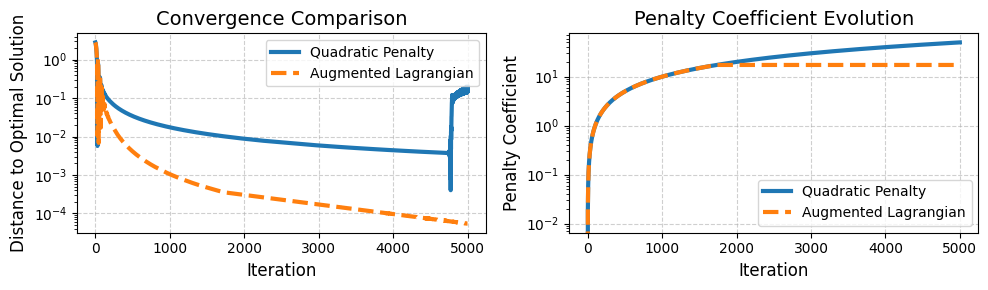

In [11]:
plt.figure(figsize=(10, 3))

# Plot distance to optimal solution
plt.subplot(1, 2, 1)
plt.plot(dist_qp, label="Quadratic Penalty", linewidth=3)
plt.plot(dist_al, label="Augmented Lagrangian", linewidth=3, linestyle="dashed")
plt.yscale("log")
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Distance to Optimal Solution", fontsize=12)
plt.title("Convergence Comparison", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Plot penalty coefficients
plt.subplot(1, 2, 2)
plt.plot(qp_penalty_coefficients, label="Quadratic Penalty", linewidth=3)
plt.plot(al_penalty_coefficients, label="Augmented Lagrangian", linewidth=3, linestyle="dashed")
plt.yscale("log")
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Penalty Coefficient", fontsize=12)
plt.title("Penalty Coefficient Evolution", fontsize=14)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()